In [1]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [2]:
# install envs 
!pip install diffusers["torch"]
!pip install accelerate
!pip install datasets
!pip install transformers
!pip install diffusers
!pip install bitsandbytes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.8/212.8 KB 12.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 K

In [3]:
# imports
import numpy as np
import huggingface_hub
from dataclasses import dataclass
import torch.nn.functional as F
import os
from huggingface_hub import HfFolder, Repository, whoami

In [4]:
# hugging_face login
huggingface_hub.login('KEYS Here', True)

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
# set config

@dataclass
class set_Config():
    resolution = 512
    gradient_accumlation_steps = 32
    mixed_precision = 'fp16'
    learning_rate = 1e-05
    train_batch_size = 1
    num_train_epochs = 1500
    saved_every_epoch = 5
    eval_every_epoch = 5
    lr_scheduler = 'constant'
    lr_warmup_steps = 0
    push_to_hub = True
    output_dir = './vivian'
    local_dir = './local_vivian' # to save some local checkpoints to save some space for online repos
    test = False # to save gpu resources when testing
    pre_trained_path = 'CompVis/stable-diffusion-v1-4'
    report_to = 'tensorboard'
    logging_dir = './log'
    repo_name = 'cQueenccc/Fine-Tune-Diffusion-Vivian' 
    dataset = "cQueenccc/Vivian-Blip-Captions"

config = set_Config()

os.mkdir(config.output_dir)
os.mkdir(config.local_dir)

if not config.test:
    repo = Repository(config.output_dir, clone_from=config.repo_name)

In [8]:
# get dataset
from datasets import load_dataset

dataset = load_dataset(config.dataset, split='train', cache_dir = './data')

if config.test:
    dataset = dataset.select(range(100))

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1087 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /content/data/cQueenccc___parquet/cQueenccc--Vivian-Blip-Captions-32b69f75ccd370e3/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


In [25]:
# set random seeds 
seed = 9527
np.random.seed(seed)

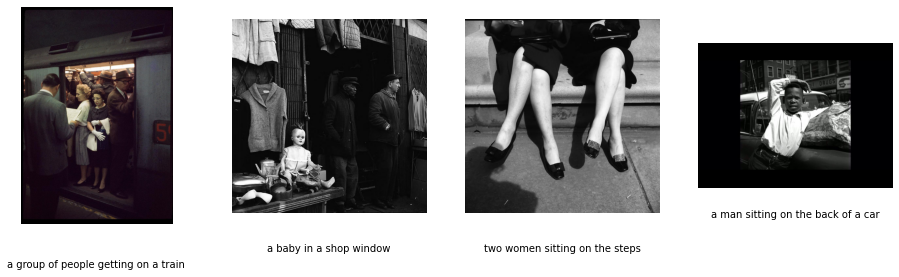

In [26]:
# inspect the dataset
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize =(16,4))
indexs = np.random.randint(0, len(dataset), 4)
sample_data = dataset[indexs]
for i in range(len(indexs)):
  axs[i].imshow(sample_data['image'][i])
  axs[i].set_axis_off()
  axs[i].text(0.5, -0.2, sample_data['caption'][i], fontsize=10, ha='center', transform=axs[i].transAxes)

In [27]:
# transform functions {image -> tensor, text -> tokens}
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
import random
from torchvision import transforms
import torch

tokenizer = CLIPTokenizer.from_pretrained(config.pre_trained_path, subfolder="tokenizer")

def tokenize_captions(examples, is_train=True):
  captions = []
  for caption in examples['caption']:
    if isinstance(caption, str):
      captions.append(caption)
    elif isinstance(caption, (list, np.ndarray)):
      captions.append(random.choice(caption) if is_train else caption[0])
    else:
      raise ValueError(
          "text should be either strings or lists of strings"
      )
  inputs = tokenizer(captions, max_length=tokenizer.model_max_length, padding='do_not_pad', truncation=True)
  input_ids = inputs.input_ids
  return input_ids

preprocess = transforms.Compose(
    [
        transforms.RandomCrop(config.resolution * 1.18),
        transforms.Resize((config.resolution, config.resolution), interpolation = transforms.InterpolationMode.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]
)

# prepare for the dataloader to load the data form a map based dataset
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    input_ids = [example["input_ids"] for example in examples]
    padded_tokens = tokenizer.pad({"input_ids": input_ids}, padding=True, return_tensors="pt")
    return {
        "pixel_values": pixel_values,
        "input_ids": padded_tokens.input_ids
    }

In [28]:
# data preprocess 

def transform(examples):
  images = [preprocess(image.convert('RGB')) for image in examples['image']]
  captions = tokenize_captions(examples)
  return {'pixel_values': images,
          'input_ids': captions}

dataset.set_transform(transform)

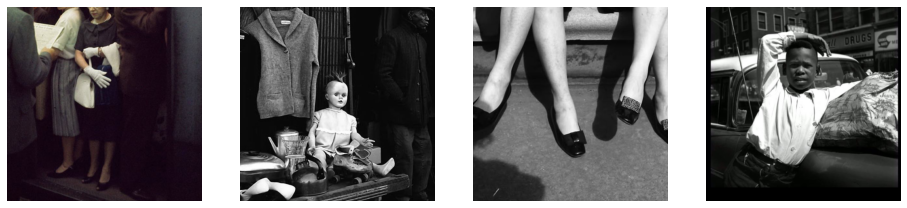

In [ ]:
# inspect the transformed dataset

fig, axs = plt.subplots(1, 4, figsize =(16,4))
sample_data = dataset[indexs]
for i, image in enumerate(sample_data["pixel_values"]):
  axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
  axs[i].set_axis_off()

In [ ]:
# pre-define the promts during eval

import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True, collate_fn=collate_fn)

val_promts = ['Yoda',
'Obama',
'Elon Musk',
'A woman walking down the street',
'A child in a car',
"a group of people getting on a bus",
'two men working on a construction site']

val_promts = [x.strip() for x in val_promts]

In [ ]:
import os
from accelerate import Accelerator
logging_dir = os.path.join(config.output_dir, 'log')

In [ ]:
# preparing the models from pretrained checkpoints

from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
import math

text_encoder = CLIPTextModel.from_pretrained(config.pre_trained_path, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(config.pre_trained_path, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(config.pre_trained_path, subfolder="unet")

# Freeze vae and text_encoder
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.enable_gradient_checkpointing()

optimizer = torch.optim.AdamW(unet.parameters(), lr=config.learning_rate,  betas=(0.9, 0.999), weight_decay=1e-2, eps=1e-08)

noise_scheduler = DDPMScheduler(
        beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000
    )

num_update_steps_per_epoch = math.ceil(len(train_dataloader) / config.gradient_accumlation_steps)
config.max_train_steps = config.num_train_epochs * num_update_steps_per_epoch
lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=config.lr_warmup_steps * config.gradient_accumlation_steps,
        num_training_steps=config.max_train_steps * config.gradient_accumlation_steps,
    )

In [ ]:
# eval
def eval(config, epoch, promts, text_encoder, vae, unet, toknizer, device=None, repo=None):
    pipeline = StableDiffusionPipeline(
                text_encoder=text_encoder,
                vae=vae,
                unet=unet,
                tokenizer=tokenizer,
                scheduler=PNDMScheduler(
                    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", skip_prk_steps=True
                ),
                safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
                feature_extractor=CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32"),
            )
  
    n_samples, scale, steps = 1, 7.5, 50
    if device is not None:
        pipeline.to(device)

    for prompt in promts:
        os.makedirs(f"{config.output_dir}/eval/{prompt}", exist_ok=True)
        images = pipeline(prompt, guidance_scale=scale, num_inference_steps=steps).images
        
        for idx, im in enumerate(images):
            im.save(f"{config.output_dir}/eval/{prompt}/{prompt}_{epoch}_{idx:06}.png")
    
    
    pipeline.save_pretrained(os.path.join(config.output_dir, 'saved_model'))
    pipeline.save_pretrained(os.path.join(config.local_dir, f'saved_model_{epoch}'))
    del pipeline
    
    if repo is not None:
        repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=False, auto_lfs_prune=True)
    
    
test = False
if test:
    eval(config, -1, val_promts, text_encoder, vae, unet, tokenizer, 'cuda')

In [ ]:
# train loop
from tqdm.auto import tqdm
import os

def train_loop(config, noise_scheduler, optimizer, train_dataloader, lr_scheduler,
               prompts, text_encoder, vae, unet, toknizer, repo):
    accelerator = Accelerator(
        gradient_accumulation_steps=config.gradient_accumlation_steps,
        mixed_precision='fp16', #whether to use a mixed precision (fp16 & bf16)
        log_with=config.report_to, # usually go to the tensorborad
        logging_dir=os.path.join(config.output_dir, "logs")
    )

    if accelerator.is_main_process:
        accelerator.init_trackers("train_example")

    vae.to(accelerator.device)
    text_encoder.to(accelerator.device)

    unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, optimizer, train_dataloader, lr_scheduler
    )

    #ema_unet = EMAModel(unet)

    global_step = 0 

    for epoch in range(config.num_train_epochs):
        progress_bar = tqdm(total=num_update_steps_per_epoch, disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")
        train_loss = 0.0

        for step, batch in enumerate(train_dataloader):

            unet.train()

            # accumulate the gradient to simulate batch gradient descent 
            with accelerator.accumulate(unet):
             # Predict the noise residual
                imgs = batch['pixel_values']

                # compute the latents using the pretrained vae
                latents = vae.encode(imgs).latent_dist.sample()
                latents = 0.18215 * latents

                # generate the noise for reparameterized trick
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]

                # get the noisy latents using scheduler
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device = latents.device).long()
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # predict the original image under the condition of the caption's embedding
                encoder_hiddenstates = text_encoder(batch['input_ids'])[0]
                noisy_pred = unet(noisy_latents, timesteps, encoder_hiddenstates).sample
                
                loss = F.mse_loss(noisy_pred, noise, reduction="mean")
                avg_loss = accelerator.gather(loss.repeat(config.train_batch_size)).mean()
                train_loss += avg_loss.item() / config.gradient_accumlation_steps
                
                accelerator.backward(loss)
                
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), 1.0)
                    
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                train_loss = 0.0
                
                logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
                accelerator.log(logs, step=global_step)
                progress_bar.set_postfix(**logs)


        if accelerator.is_main_process:
            # eval the image and uplaod the model to the repo
            if (epoch + 1) % config.eval_every_epoch == 0 or epoch == config.num_train_epochs - 1:
                eval(config, epoch+1, prompts, text_encoder, vae, unet, toknizer, accelerator.device, repo)

In [ ]:
from accelerate import notebook_launcher
args = (config, noise_scheduler, optimizer, train_dataloader, lr_scheduler, val_promts, text_encoder, vae, unet, tokenizer, repo)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


/home/ubuntu/.local/lib/python3.8/site-packages/accelerate/accelerator.py:243: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


/home/ubuntu/.local/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:106: FutureWarning: The configuration file of this scheduler: PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.14.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 0,
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkp

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['eval/A child in a car/.ipynb_checkpoints/A child in a car_5_000000-checkpoint.png', 'eval/A child in a car/A child in a car_5_000000.png', 'eval/A woman walking down the street/A woman walking down the street_5_000000.png', 'eval/Elon Musk/Elon Musk_5_000000.png', 'eval/Obama/Obama_5_000000.png', 'eval/Yoda/Yoda_5_000000.png', 'eval/a group of people getting on a bus/a group of people getting on a bus_5_000000.png', 'eval/two men working on a construction site/two men working on a construction site_5_000000.png']. This may take a bit of time if the files are large.


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/home/ubuntu/.local/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:106: FutureWarning: The configuration file of this scheduler: PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.14.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 0,
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to upda

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['eval/A child in a car/A child in a car_10_000000.png', 'eval/A woman walking down the street/.ipynb_checkpoints/A woman walking down the street_5_000000-checkpoint.png', 'eval/A woman walking down the street/A woman walking down the street_10_000000.png', 'eval/Elon Musk/.ipynb_checkpoints/Elon Musk_5_000000-checkpoint.png', 'eval/Elon Musk/Elon Musk_10_000000.png', 'eval/Obama/.ipynb_checkpoints/Obama_5_000000-checkpoint.png', 'eval/Obama/Obama_10_000000.png', 'eval/Yoda/.ipynb_checkpoints/Yoda_5_000000-checkpoint.png', 'eval/Yoda/Yoda_10_000000.png', 'eval/a group of people getting on a bus/.ipynb_checkpoints/a group of people getting on a bus_5_000000-checkpoint.png', 'eval/a group of people getting on a bus/a group of people getting on a bus_10_000000.png', 'eval/two men working on a construction site/.ipynb_checkpoints/two men working on a construction site_5_000000-checkpoint.png', 'eval/two men working on a construction site/two men working on 

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/home/ubuntu/.local/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:106: FutureWarning: The configuration file of this scheduler: PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.14.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 0,
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to upda

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['eval/A child in a car/A child in a car_15_000000.png', 'eval/A woman walking down the street/A woman walking down the street_15_000000.png', 'eval/Elon Musk/Elon Musk_15_000000.png', 'eval/Obama/Obama_15_000000.png', 'eval/Yoda/Yoda_15_000000.png', 'eval/a group of people getting on a bus/a group of people getting on a bus_15_000000.png', 'eval/two men working on a construction site/two men working on a construction site_15_000000.png']. This may take a bit of time if the files are large.


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/home/ubuntu/.local/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:106: FutureWarning: The configuration file of this scheduler: PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.14.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 0,
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to upda

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['eval/A child in a car/A child in a car_20_000000.png', 'eval/A woman walking down the street/A woman walking down the street_20_000000.png', 'eval/Elon Musk/Elon Musk_20_000000.png', 'eval/Obama/Obama_20_000000.png', 'eval/Yoda/Yoda_20_000000.png', 'eval/a group of people getting on a bus/a group of people getting on a bus_20_000000.png', 'eval/two men working on a construction site/two men working on a construction site_20_000000.png']. This may take a bit of time if the files are large.


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/home/ubuntu/.local/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:106: FutureWarning: The configuration file of this scheduler: PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.14.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 0,
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to upda

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['eval/A child in a car/A child in a car_25_000000.png', 'eval/A woman walking down the street/A woman walking down the street_25_000000.png', 'eval/Elon Musk/.ipynb_checkpoints/Elon Musk_20_000000-checkpoint.png', 'eval/Elon Musk/Elon Musk_25_000000.png', 'eval/Obama/.ipynb_checkpoints/Obama_20_000000-checkpoint.png', 'eval/Obama/Obama_25_000000.png', 'eval/Yoda/Yoda_25_000000.png', 'eval/a group of people getting on a bus/.ipynb_checkpoints/a group of people getting on a bus_20_000000-checkpoint.png', 'eval/a group of people getting on a bus/a group of people getting on a bus_25_000000.png', 'eval/two men working on a construction site/.ipynb_checkpoints/two men working on a construction site_20_000000-checkpoint.png', 'eval/two men working on a construction site/two men working on a construction site_25_000000.png']. This may take a bit of time if the files are large.


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/home/ubuntu/.local/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:106: FutureWarning: The configuration file of this scheduler: PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.14.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 0,
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to upda

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['eval/A child in a car/A child in a car_30_000000.png', 'eval/A woman walking down the street/A woman walking down the street_30_000000.png', 'eval/Elon Musk/Elon Musk_30_000000.png', 'eval/Obama/Obama_30_000000.png', 'eval/Yoda/Yoda_30_000000.png', 'eval/a group of people getting on a bus/a group of people getting on a bus_30_000000.png', 'eval/two men working on a construction site/two men working on a construction site_30_000000.png']. This may take a bit of time if the files are large.


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/home/ubuntu/.local/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:106: FutureWarning: The configuration file of this scheduler: PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.14.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 0,
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to upda

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['eval/A child in a car/A child in a car_35_000000.png', 'eval/A woman walking down the street/A woman walking down the street_35_000000.png', 'eval/Elon Musk/.ipynb_checkpoints/Elon Musk_10_000000-checkpoint.png', 'eval/Elon Musk/.ipynb_checkpoints/Elon Musk_15_000000-checkpoint.png', 'eval/Elon Musk/.ipynb_checkpoints/Elon Musk_25_000000-checkpoint.png', 'eval/Elon Musk/.ipynb_checkpoints/Elon Musk_30_000000-checkpoint.png', 'eval/Elon Musk/Elon Musk_35_000000.png', 'eval/Obama/Obama_35_000000.png', 'eval/Yoda/.ipynb_checkpoints/Yoda_10_000000-checkpoint.png', 'eval/Yoda/.ipynb_checkpoints/Yoda_15_000000-checkpoint.png', 'eval/Yoda/.ipynb_checkpoints/Yoda_20_000000-checkpoint.png', 'eval/Yoda/.ipynb_checkpoints/Yoda_25_000000-checkpoint.png', 'eval/Yoda/.ipynb_checkpoints/Yoda_30_000000-checkpoint.png', 'eval/Yoda/Yoda_35_000000.png', 'eval/a group of people getting on a bus/.ipynb_checkpoints/a group of people getting on a bus_25_000000-checkpoint.pn

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/home/ubuntu/.local/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:106: FutureWarning: The configuration file of this scheduler: PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.14.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 0,
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to upda

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['eval/A child in a car/A child in a car_40_000000.png', 'eval/A woman walking down the street/A woman walking down the street_40_000000.png', 'eval/Elon Musk/Elon Musk_40_000000.png', 'eval/Obama/Obama_40_000000.png', 'eval/Yoda/Yoda_40_000000.png', 'eval/a group of people getting on a bus/a group of people getting on a bus_40_000000.png', 'eval/two men working on a construction site/two men working on a construction site_40_000000.png']. This may take a bit of time if the files are large.


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/home/ubuntu/.local/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:106: FutureWarning: The configuration file of this scheduler: PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.14.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 0,
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to upda

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['eval/A child in a car/A child in a car_45_000000.png', 'eval/A woman walking down the street/A woman walking down the street_45_000000.png', 'eval/Elon Musk/Elon Musk_45_000000.png', 'eval/Obama/Obama_45_000000.png', 'eval/Yoda/Yoda_45_000000.png', 'eval/a group of people getting on a bus/a group of people getting on a bus_45_000000.png', 'eval/two men working on a construction site/two men working on a construction site_45_000000.png']. This may take a bit of time if the files are large.


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/home/ubuntu/.local/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:106: FutureWarning: The configuration file of this scheduler: PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.14.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 0,
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to upda

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['eval/A child in a car/A child in a car_50_000000.png', 'eval/A woman walking down the street/A woman walking down the street_50_000000.png', 'eval/Elon Musk/Elon Musk_50_000000.png', 'eval/Obama/Obama_50_000000.png', 'eval/Yoda/Yoda_50_000000.png', 'eval/a group of people getting on a bus/a group of people getting on a bus_50_000000.png', 'eval/two men working on a construction site/two men working on a construction site_50_000000.png']. This may take a bit of time if the files are large.


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]